# Tutorial on Variational Quantum Eigensolver (Part IV)
# Quantum Phase Estimation to estimate Energy

---
This code was mostly based on Qiskit Variational Quantum Eigensolver Playground, you can find in [Github](https://github.com/JavaFXpert/vqe-playground). Please run all the cells in order.

We try to get the energy estimation in this Notebook with the [QPE: Quantum Phase estimation Algorithm.](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm)

Part of the QPE is the [I-QFT: Inverse Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform)

We detail the steps in the Notebook but we end up with the conclusion that it is **not the best way to proceed**.

The prerequisite of QPE is that the Ansatz or wavefunction used as input is a very good aproximationt to the actual Eigenvector we are looking for. Hence it will not really serve our purposes and we will see that there is not even convergence in the majority of the cases.


## Import libraries  

We import all necessary functions from IBM qiskit and numpy python **libraries**, that we will later use on this Notebook.

In [9]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.circuit.library import QFT
from qiskit.circuit import Gate
from qiskit.visualization import plot_bloch_multivector, plot_histogram

print("Libraries loaded successfully.")

Libraries loaded successfully.


## Definition of the Circuit
We already went through the details of classes `CircuitGridNode` and `CircuitGridModel` in PART I 

In [10]:
class CircuitGridNode():
    def __init__(self, node_type, radians=0.0, ctrl_a=-1):
        self.node_type = node_type
        self.radians = radians
        self.ctrl_a = ctrl_a
        self.wire_num = -1
        self.column_num = -1

For the Class: **`CircuitGridModel`** , we are going to add the extra Quantum Circuit necessary to do the Hamiltonian expectation value and the corresponding measurement. In this 'Brute Force' PartII tutorial we will just meassure the 5 qubits. 

Hence we are not adding extra quibits or Gates in the initialization segment now.

In [41]:
class CircuitGridModel():

    def __init__(self):
        # Define the Quantum Circuit to generate the Ansatz + Other Measurement Circuit
        self.max_wires = NUM_QUBITS
        self.max_columns = 21        # Columns for the circuit. 21 Columns for the Entanglement/Tuning Circuit
                                     # NUM_QUBITS_PHASE extra phase qubits, 3 extra columns for Hadamard and Control Z.
        self.nodes = np.empty((self.max_wires + NUM_QUBITS_PHASE, self.max_columns + 3),
                                dtype = CircuitGridNode)
                
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                if column_num % 5 == 0:
                    self.nodes[wire_num][column_num] = CircuitGridNode(Ygate, np.pi)              # Ry(pi)
                    self.nodes[wire_num][column_num].wire_num = wire_num
                    self.nodes[wire_num][column_num].column_num = column_num
                else: 
                    if wire_num != 0 and wire_num == column_num % 5:
                        self.nodes[wire_num][column_num] = CircuitGridNode(Xgate, 0, wire_num-1)  # CNOT 
                        self.nodes[wire_num][column_num].wire_num = wire_num
                        self.nodes[wire_num][column_num].column_num = column_num
                        
        for wire_num in range(NUM_QUBITS_PHASE):
                    self.nodes[wire_num+NUM_QUBITS][21] = CircuitGridNode(Hgate)                  # Hadamard 
                    self.nodes[wire_num+NUM_QUBITS][21].wire_num = wire_num+NUM_QUBITS  
                    self.nodes[wire_num+NUM_QUBITS][21].column_num = 21      
                    
        # Control H_i                    
        self.nodes[5][22] = CircuitGridNode(Zgate, 5, 4)  # CZ4    we initialize with Z3 Z4 as example 
        self.nodes[5][23] = CircuitGridNode(Zgate, 5, 3)  # CZ3    
        self.nodes[5][22].wire_num = 5  ;  self.nodes[5][22].column_num = 22
        self.nodes[5][23].wire_num = 5  ;  self.nodes[5][23].column_num = 23

    def Control_Hi(self, index):
        # Make the Hadamard Test Circuit different for each and every H sum Term
        # H1 = (3/2)Z0Z1   ;   H2 = (1/2)Z0Z2   ;   H3 = (3/2)Z0Z3
        # H4 = (3/2)Z2Z3   ;   H5 = (2/2)Z1Z4   ;   H6 = (2/2)Z3Z4 
        if index == 0:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 0)  # CZ0
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 1)  # CZ1   
        elif index == 1:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 0)  # CZ0
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 2)  # CZ2   
        elif index == 2:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 0)  # CZ0
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 3)  # CZ3   
        elif index == 3:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 2)  # CZ2
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 3)  # CZ3   
        elif index == 4:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 1)  # CZ1
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 4)  # CZ4   
        elif index == 5:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 3)  # CZ3
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 4)  # CZ4   

    def get_rotation_gate_nodes(self):
        rot_gate_nodes = []
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node and node.node_type == Ygate:
                    rot_gate_nodes.append(node)
        return rot_gate_nodes
  
    def qft_dagger(self, qcc, n):
        # Don't forget the Swaps!
        for qubit in range(n//2):
            qcc.swap(qubit+NUM_QUBITS, n+NUM_QUBITS-qubit-1)
        for j in range(n):
            for m in range(j):
                qcc.cp(-np.pi/float(2**(j-m)), m+NUM_QUBITS, j+NUM_QUBITS)
            qcc.h(j+NUM_QUBITS)
    
    def compute_circuit(self):
        qr = QuantumRegister(NUM_QUBITS, 'q')
        qp = QuantumRegister(NUM_QUBITS_PHASE, 'phase')
        cr = ClassicalRegister(NUM_QUBITS_PHASE, 'c')
        qc = QuantumCircuit(qr, qp, cr)
        # Build the Circuit with actual gates based on the Circuit Grid Model
        for column_num in range(self.max_columns+3):
            qc.barrier(qr) ; qc.barrier (qp) ; qc.barrier (qp)
            for wire_num in range(self.max_wires+NUM_QUBITS_PHASE):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == Xgate:    qc.cx(node.ctrl_a, wire_num)       # Controlled X gate
                    elif node.node_type == Ygate:  qc.ry(node.radians, wire_num)      # Rotation around Y axis
                    elif node.node_type == Zgate:  qc.cz(node.ctrl_a, wire_num)       # Controlled Z gate
                    elif node.node_type == Hgate:  qc.h(wire_num)                     # Hadamard Gate
                        
        # Append an Inverse QFT circuit of the correct size:
        # Note this QFT should be reversed in Qubits! - as it is , its applying QFT upside down
        #qc.append(QFT(num_qubits=NUM_QUBITS_PHASE, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=True, name='InverseQFT'),qc)
        
        # Manual IQFT
        self.qft_dagger(qc, NUM_QUBITS_PHASE)
        qc.barrier(qr)
        qc.barrier(qp)
        # Add Measurement at the end
        qc.measure(qp, cr) 
        
        return qc

    def compute_circuit_ansatz(self):
        # Function aimed to measure the final Ansatz
        qr = QuantumRegister(NUM_QUBITS, 'q')
        cr = ClassicalRegister(NUM_QUBITS, 'c')
        qc = QuantumCircuit(qr, cr)
    
        # Build the Circuit with actual gates based on the Circuit Grid Model
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == Xgate:    qc.cx(node.ctrl_a, wire_num)       # Controlled X gate
                    elif node.node_type == Ygate:  qc.ry(node.radians, wire_num)      # Rotation around Y axis
        
        # Add Measurement at the end
        qc.measure(qr, cr)       
        return qc

## Global Functions:

`ExperimentAndMeasure` Sets up the Qiskit Simulator, Executes the simulation `n_experiments` times and return the results as an histogram (dictionary of results in the format: {'000': n1, '001': n2 ....}). In this case we will be measuring only the ancilla qubit.

Also we define an array with all de weights of the $H_i$ and a temporary array `Energies_Hi` that will help us store the partial expectation values as we go calculating each one of the 6 terms of the sum.

In [33]:
# H1 = (3/2)Z0Z1   ;   H2 = (1/2)Z0Z2   ;   H3 = (3/2)Z0Z3
# H4 = (3/2)Z2Z3   ;   H5 = (2/2)Z1Z4   ;   H6 = (2/2)Z3Z4 
Sum_Term_Weights = [3/2,1/2,3/2,3/2,1,1]          # This array will hold the weight of every H_i term.
Energies_Hi = [0,0,0,0,0,0]                       # This will hold the expectation Values of the terms H_i.

def ExperimentAndMeasure(circuit):
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circuit, backend_sim, shots=n_experiments)
    result_sim = job_sim.result()
    prob_distro = result_sim.get_counts(circuit)
    return prob_distro

def Phasedict_to_number(prob_distro):
    Prob_i=[]
    for name in basis_states_phase:
        prob_distro.setdefault(name, 0)
        Prob_i.append(float(prob_distro.get(name))/n_experiments)
    return np.argmax(Prob_i)

def Ansatzdict_to_number(prob_distro):
    Prob_i=[]
    for name in basis_states:
        prob_distro.setdefault(name, 0)
        Prob_i.append(float(prob_distro.get(name))/n_experiments)
    return np.argmax(Prob_i)

## Global Function to Recalculate Circuit and Recalculate Expectation Value 
This function will first make use of the array `optimized_rotations` that hold the latest optimal angles for all the Ry Gates. It will assign those angles to the nodes contained in `rotation_gate_nodes` which are the nodes in the circuit subject to rotation (Ry).

After that, it will compute the new circuit in the Class `circuit_grid_model` and will obtain the ansatz state and Measure it correspondingly with `ExperimentAndMeasure`. 

That function will in turn give the probability distribution that will be input in the `calc_expectation_value` function that at last will return the estimated Energy, most probable base state and the actual probability distribution as well.

In [34]:
def calc_new_energy(circuit_grid_model, rotation_gate_nodes):
    
    for idx in range(len(rotation_gate_nodes)):
        rotation_gate_nodes[idx].radians = optimized_rotations[idx]
        
    for i in range(6):
        circuit_grid_model.Control_Hi(i)
        circuit = circuit_grid_model.compute_circuit()
        prob_distro = ExperimentAndMeasure(circuit)
        angle = Phasedict_to_number(prob_distro) * 2 * np.pi / (2**NUM_QUBITS_PHASE)     # Estimated Phase
        Energies_Hi[i] = Sum_Term_Weights[i] * np.cos(angle)                             # Estimated Eigenval
        #print(circuit)
        #print(prob_distro)
        #print("phase:",Phasedict_to_number(prob_distro))
        
    #print (Energies_Hi)
    estimated_Energy = sum(Energies_Hi)
    return estimated_Energy

## Global Function to Optimize Rotations
This function will contain the **classical optimization algorithm** to finetune the angles and make sure that the Energy of the resulting state will be minimal.

As input it will gate the, the Class with the Circuit, the Class with the Expectation grid and the array of nodes with Ry Gates. As output it will proyect the latest optimized energy the variable `energy` and the latest *optimal* basis state (basis state with highest probability) 

`cur_rotation_num` will be the node containing the Ry Gate currently being updated and optimized. Will be a counter 25 times. For each gate, the algorithm will start rotating a fixed angle on one direction, if the Energy stays or decreasis it will continue rotating, if it increases, then it will change direction of rotation unless it already changed direction before. In that case or if the angle is out of the $ [0,2\pi] $ range, it will move to the next gate.  

In [47]:
def optimize_rotations(circuit_grid_model, rotation_gate_nodes):
    global energy, move_radians, cur_rotation_num, rot_direction, Fin_optimizacion

    if cur_rotation_num < len(optimized_rotations):   # Are we on the last Ry Gate?
        cur_ang_rad = optimized_rotations[cur_rotation_num]
        proposed_cur_ang_rad = cur_ang_rad
        proposed_cur_ang_rad += move_radians * rot_direction
        
        if (0.0 <= proposed_cur_ang_rad <= np.pi * 2 + 0.01) and (num_times_rot_dir_change[cur_rotation_num]<2):
            optimized_rotations[cur_rotation_num] = proposed_cur_ang_rad               
            
            # Calculate new Energy with the new Circuit, Quantum Qiskit circuit is called here.
            temp_energy = calc_new_energy(circuit_grid_model, rotation_gate_nodes)
            if temp_energy > energy: 
                # NOT OPTIMIZED. Distance is increasing so restore the angle and change direction of rot
                optimized_rotations[cur_rotation_num] = cur_ang_rad
                rot_direction *= -1
                num_times_rot_dir_change[cur_rotation_num] += 1
            else:
                # OPTIMIZED or equal. Distance decreasing, so keep the proposed angle and update Energy
                energy = temp_energy
        else:                                       
            cur_rotation_num += 1       # Out of [0,2pi] range or changed direction twice. Move to next Gate.
    else:
        Fin_optimizacion = True         # We reached the last Ry, optimization process is over    
    
    return energy

## Definitions and Initializations
In this segment of code we will initialize global variables that will be used in the Main and optimization algorithm. One of the important variables is the Rotation step. Note the Adjacency Matrix does not show up as it is embedded in the Hamiltonian we have manually calculated.

In [59]:
NUM_QUBITS = 5                                                 # Qubits to model the problem
NUM_QUBITS_PHASE = 5                                          # Qubits to code the phase in QPE
Xgate = 1 ; Ygate = 2 ; Zgate = 3 ; Hgate = 4                  # Gate Definitions     
basis_states_phase = []                                        # List of Basis states in Text format
for idx in range(2**NUM_QUBITS_PHASE):
    state = format(idx, '0' + str(NUM_QUBITS_PHASE) + 'b')
    basis_states_phase.append(state)
basis_states = []  
for idx in range(2**NUM_QUBITS):
    state = format(idx, '0' + str(NUM_QUBITS) + 'b')
    basis_states.append(state)
    
n_experiments = 512
cur_rotation_num = 0
proposed_cur_ang_rad = 0
cur_ang_rad = 0
rot_direction = 1
move_radians = np.pi / 5                # Rotation Step

## Initialization of the Circuit and Visual Output
Here we will initialize the circuit for first time and will calculate the Ansatz State of the all the Ry gates with $\pi$ radians. Also it will create the expectation grid for the first time.

When the expectation grid is initialized, it will convert the Adjacency matrix to the Ising Hamiltonian and will print its output in gate format (I and Z gates)

On this piece of code we also print the Quantum Optimization Circuit using the Qiskit drawing capabilities as well as the Latex output extensions included in the Qiskit programming language to show the Adjacency Matrix in a readable manner.


Complete Quantum Circuit:


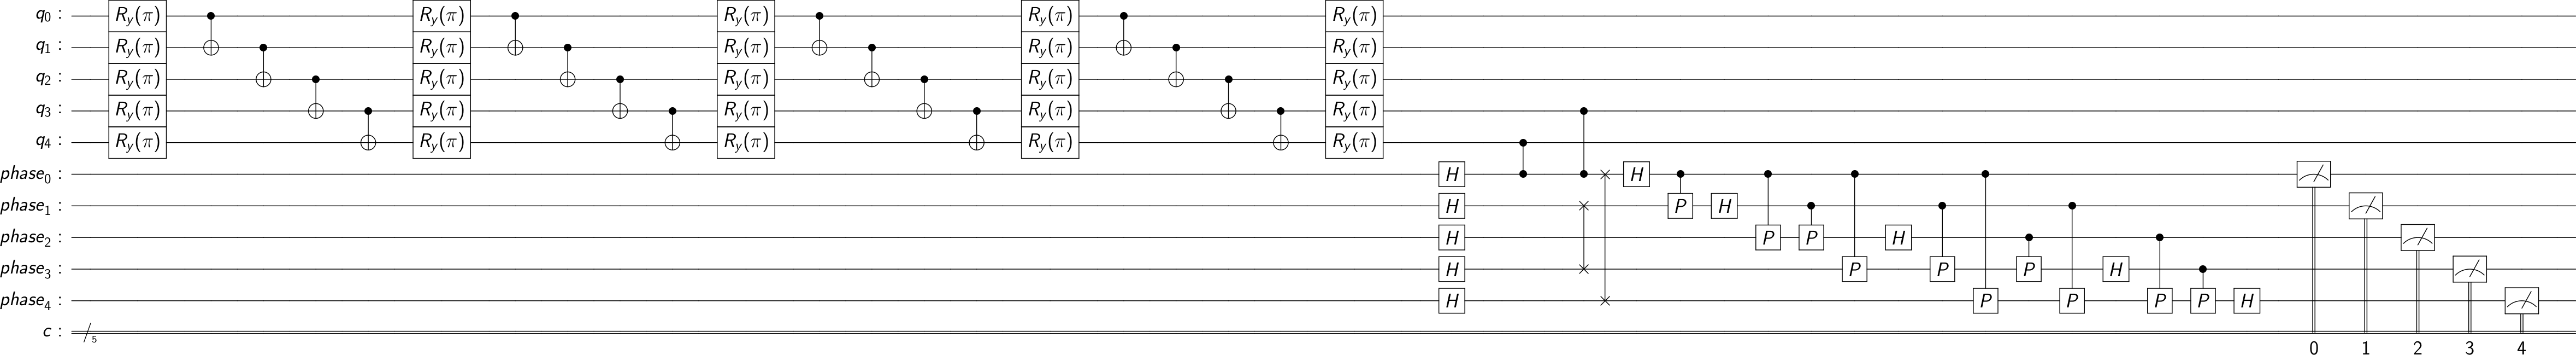

In [60]:
circuit_grid_model = CircuitGridModel()
circuit = circuit_grid_model.compute_circuit()

print("\nComplete Quantum Circuit:")
display(circuit.draw(output='latex', scale=0.7, plot_barriers=False))

# In case we want to see inside the InverseQFT:
# decomposed_circuit = circuit.decompose() 
# display(decomposed_circuit.draw(output='latex',scale=0.7,plot_barriers=False))

## Main Loop and Print Results
First extract all nodes with gates suitable for rotation ans intialize first rotation of those with $\pi$. At the beginning, all Ry Gates will be indeed Pauli Y Gates.

After that we will run the first Optimization iteration befor going to the actual main loop.

In the main loop showing as a `while` we will **print** the Iteration number, the rotating gate, the position in the 5x21 matrix, the energy of this iteration, and the optimal basis state so far.

Then we will try to **optimize** calling `optimize_rotations` function. During the optimization we will also print the simulated Ansatz State that results after the optimization quantum circuit. The output will be a **sum of the basis states and its probability**.

Once the optimization comes to an end and we get out of the loop we will print the final Energy and Optimal Base State as a result

In [61]:
circuit_grid_model = CircuitGridModel()
circuit = circuit_grid_model.compute_circuit()

# INITIALIZATION OF FIRST CIRCUIT AND FIRST ENERGY
# Random angles at the beginning
rotation_gate_nodes = circuit_grid_model.get_rotation_gate_nodes()
#optimized_rotations = np.full(len(rotation_gate_nodes), 2 * np.pi * np.random.default_rng().random())
optimized_rotations = np.full(len(rotation_gate_nodes), np.pi)
iteration=0

energy = calc_new_energy(circuit_grid_model, rotation_gate_nodes)

# MAIN OPTIMIZATION LOOP    
nloops = 1
for i in range(nloops):
    Fin_optimizacion = False  
    cur_rotation_num = 0
    num_times_rot_dir_change = np.zeros(len(optimized_rotations))
    while not Fin_optimizacion:
        if cur_rotation_num != len(optimized_rotations):
            print(' Iteration #' + str(iteration+1) , ', Rotating Gate #' , str(cur_rotation_num+1) , 
            '(Wire, Column) = (', rotation_gate_nodes[cur_rotation_num].wire_num+1, ',' , 
            rotation_gate_nodes[cur_rotation_num].column_num+1, '). Energy:', "{:.6f}".format(energy))
        energy = optimize_rotations(circuit_grid_model, rotation_gate_nodes)
        iteration +=  1

# Extract the latest Ansatz (near EigenState) for the Histogram given the latest optimization circuit
circuit = circuit_grid_model.compute_circuit_ansatz()
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(circuit, backend_sim, shots=1024)
result_sim = job_sim.result()
prob_distro = result_sim.get_counts(circuit)

# PRINT FINAL RESULT        
print("\n-------------------------------------------------------- \n")
print('Final Energy: ', "{:.6f}".format(np.real(energy)))
print("\n-------------------------------------------------------- \n")
print('Final Ansatz:',prob_distro)
print("\n-------------------------------------------------------- \n")
print('Most probable state:',format(Ansatzdict_to_number(prob_distro),'05b'))
print("\n-------------------------------------------------------- \n")

 Iteration #1 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.000000
 Iteration #2 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.000000
 Iteration #3 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.000000
 Iteration #4 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -2.000000
 Iteration #5 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -2.000000
 Iteration #6 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -2.000000
 Iteration #7 , Rotating Gate # 2 (Wire, Column) = ( 2 , 1 ). Energy: -2.000000
 Iteration #8 , Rotating Gate # 2 (Wire, Column) = ( 2 , 1 ). Energy: -2.000000
 Iteration #9 , Rotating Gate # 2 (Wire, Column) = ( 2 , 1 ). Energy: -2.000000
 Iteration #10 , Rotating Gate # 2 (Wire, Column) = ( 2 , 1 ). Energy: -2.000000
 Iteration #11 , Rotating Gate # 2 (Wire, Column) = ( 2 , 1 ). Energy: -2.000000
 Iteration #12 , Rotating Gate # 2 (Wire, Column) = ( 2 , 1 ). Energy: -2.000000
 Iteration #13 , Rotating Gate # 2 (W

 Iteration #104 , Rotating Gate # 20 (Wire, Column) = ( 5 , 16 ). Energy: -7.000000
 Iteration #105 , Rotating Gate # 21 (Wire, Column) = ( 1 , 21 ). Energy: -7.000000
 Iteration #106 , Rotating Gate # 21 (Wire, Column) = ( 1 , 21 ). Energy: -7.000000
 Iteration #107 , Rotating Gate # 21 (Wire, Column) = ( 1 , 21 ). Energy: -7.000000
 Iteration #108 , Rotating Gate # 21 (Wire, Column) = ( 1 , 21 ). Energy: -7.000000
 Iteration #109 , Rotating Gate # 21 (Wire, Column) = ( 1 , 21 ). Energy: -7.000000
 Iteration #110 , Rotating Gate # 22 (Wire, Column) = ( 2 , 21 ). Energy: -7.000000
 Iteration #111 , Rotating Gate # 22 (Wire, Column) = ( 2 , 21 ). Energy: -7.000000
 Iteration #112 , Rotating Gate # 22 (Wire, Column) = ( 2 , 21 ). Energy: -7.000000
 Iteration #113 , Rotating Gate # 23 (Wire, Column) = ( 3 , 21 ). Energy: -7.000000
 Iteration #114 , Rotating Gate # 23 (Wire, Column) = ( 3 , 21 ). Energy: -7.000000
 Iteration #115 , Rotating Gate # 23 (Wire, Column) = ( 3 , 21 ). Energy: -7

## Histogram of Ansatz Measurements

Histogram: 


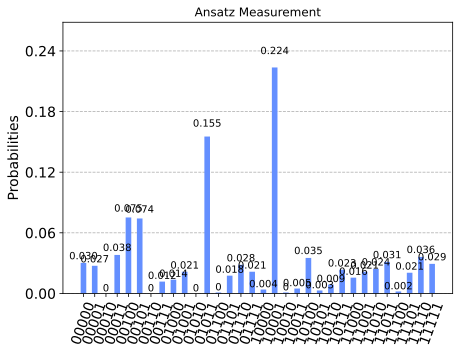

In [63]:
print('Histogram: ')
plot_histogram(prob_distro, title="Ansatz Measurement")